# Data Science Salaries

The dataset can be found [here](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

In [263]:
df = pd.read_csv("data/ds_salaries.csv")

## Data Understanding

In [360]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Preprocessing

- bag into groups: company_location, employee_residence: sort by frequeney, domain knowledge.
- no missing values
- drop salary (local currency)
- transform salary_usd to log, normalize, etc.

In [129]:
df.drop(['salary', 'Unnamed: 0'], axis=1, inplace=True)

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pycountry_convert as pc

### Country features engineering

- bag into continents
- drop countries

In [131]:
def country_to_continent(country_alpha2):
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

In [132]:
df['company_continent'] = df['company_location'].apply(lambda x: country_to_continent(x))
df['employee_residence_continent'] = df['employee_residence'].apply(lambda x: country_to_continent(x))

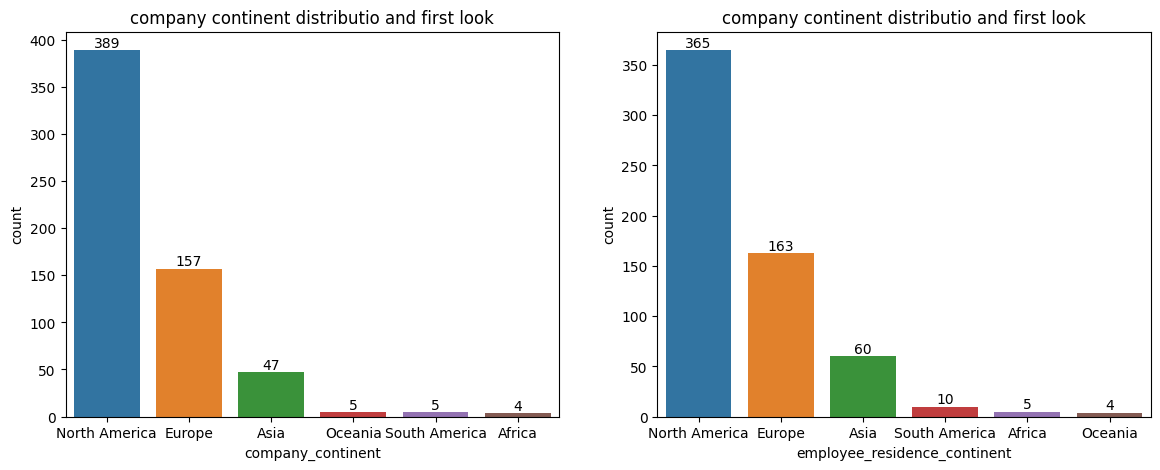

In [133]:
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
g = sns.countplot(x=df.company_continent, order = df.company_continent.value_counts().index)
g.set(title="company continent distributio and first look")
g.bar_label(g.containers[0])

plt.subplot(1, 2, 2)
g = sns.countplot(x=df.employee_residence_continent, order = df.employee_residence_continent.value_counts().index)
g.set(title="company continent distributio and first look")
g.bar_label(g.containers[0])

plt.show(g)

In [134]:
df.drop(['company_location', 'employee_residence'], axis=1, inplace=True)

- Combine Oceania, South America & Africa to an 'Other' category
- Most are in North America

In [135]:
conts = ['Oceania', 'South America', 'Africa']
df['employee_residence_continent'] = df['employee_residence_continent'].replace(conts, 'Other')
df['company_continent'] = df['company_continent'].replace(conts, 'Other')

### Job Title

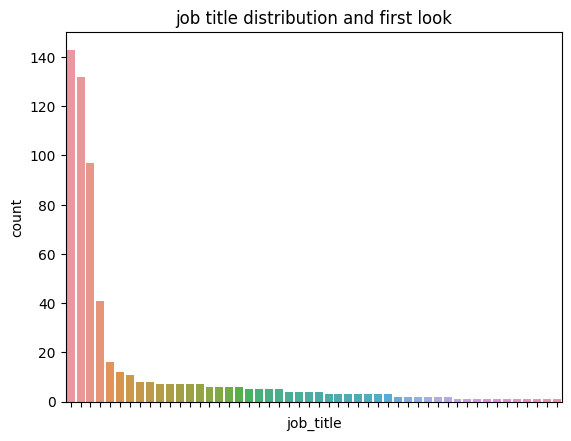

In [136]:
g = sns.countplot(x=df.job_title, order = df.job_title.value_counts().index)
g.set(title="job title distribution and first look", xticklabels=[])
plt.show()

In [137]:
def bag_of_jobs(job):

    jobs_dict = {
    'anal': 'Analyst',
    'scien': 'Scientist',
    'engine': 'Engineer',
    'devel': 'Engineer',
    'manag': 'Manager',
    'head': 'Manager'
    }

    for k, v in jobs_dict.items():
        if k in job.lower():
            return v
    return 'Other'

In [138]:
df['meta_job_title'] = df['job_title'].apply(lambda x: bag_of_jobs(x))

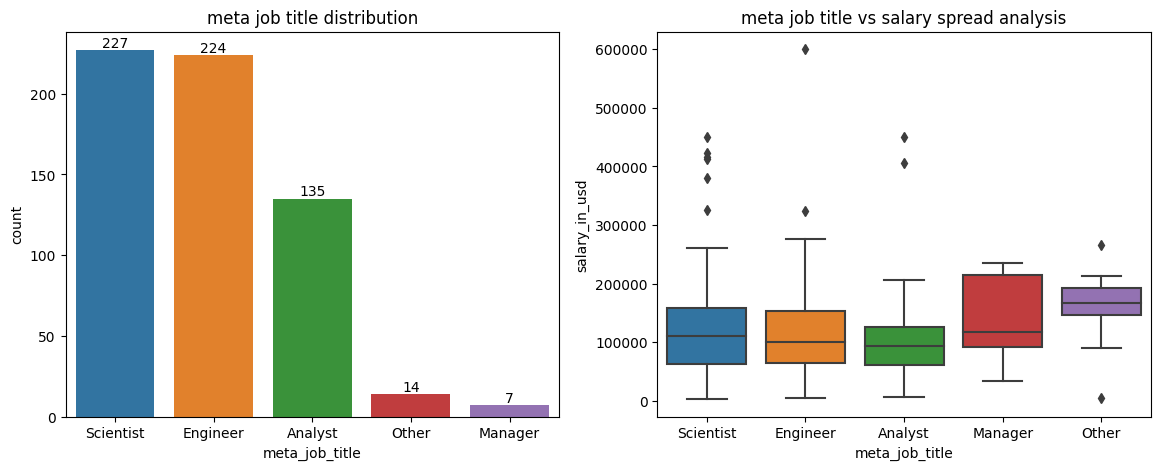

In [139]:
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
g = sns.countplot(x=df.meta_job_title, order = df.meta_job_title.value_counts().index)
g.set(title="meta job title distribution")
g.bar_label(g.containers[0])

plt.subplot(1, 2, 2)
g = sns.boxplot(data=df, x='meta_job_title', y='salary_in_usd')
g.set(title="meta job title vs salary spread analysis")
plt.show()

In [140]:
df.drop('job_title', axis=1, inplace=True)

- Note that we have reasonable spread in each group, encouraging the pick of meta job values
- Number of values in each group matches the ProfileReport values, meaning our assignment worked properly
- Removed `job_title` column

### Currency bagging into categories

- pick freq == 15 as threshold
- bag all sparse categories into a new category: Other

In [141]:
def bag_currencies(col: str, thresh: int) -> dict:
    freq = df[col].value_counts()
    mappings = freq.index.to_series().mask(freq < thresh, 'Other').to_dict()
    return mappings

In [142]:
df['salary_currency'] = df['salary_currency'].map(bag_currencies('salary_currency', 15))

## Reproducible Preprocessing 

- Implement classes that follow scikit learn API for each transformation to the data
- Insert all transformers into a preprocessing pipeline
- Incorporate the preprocessing pipeline in the model training pipeline
- Save the final model as a pickle 

In [249]:
from sklearn.base import BaseEstimator, TransformerMixin

### Setup the Transformer classes

In [329]:
class CurrencyTransformer(BaseEstimator, TransformerMixin):
    """
        All currencies which appear less than 15 times are binned to an 'Other' category
        to tackle the high cardinality in the column
    """
    def fit(self, X, y = None):
        return self

    def transform(self, X):
        freq = df['salary_currency'].value_counts()
        mappings = freq.index.to_series().mask(freq < 15, 'Other').to_dict()
        X['salary_currency'] = X['salary_currency'].map(mappings)
        return X


class JobTitleTransformer(BaseEstimator, TransformerMixin):

    def bag_of_jobs(self, job):
        """ treat individual values in the job_title column according to whether they are in the job dict """
        jobs_dict = {
            'anal': 'Analyst',
            'scien': 'Scientist',
            'engine': 'Engineer',
            'devel': 'Engineer',
            'manag': 'Manager',
            'head': 'Manager'
            }

        for k, v in jobs_dict.items():
            if k in job.lower():
                return v
        return 'Other'

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        X['meta_job_title'] = X['job_title'].apply(lambda x: self.bag_of_jobs(x))
        return X.drop('job_title', axis=1)


class CountryToContinentTransformer(BaseEstimator, TransformerMixin):

    @staticmethod
    def country_to_continent(country_alpha2):
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        # create new bagged columns
        X['company_continent'] = X['company_location'].apply(lambda x: self.country_to_continent(x))
        X['employee_residence_continent'] = X['employee_residence'].apply(lambda x: self.country_to_continent(x))

        # replace sparse categories with 'Other'
        X['employee_residence_continent'] = X['employee_residence_continent'].replace(['Oceania', 'South America', 'Africa'], 'Other')
        X['company_continent'] = X['company_continent'].replace(['Oceania', 'South America', 'Africa'], 'Other')

        return X.drop(['company_location', 'employee_residence'], axis=1)


class ColumnDropper(BaseEstimator, TransformerMixin):

    def fit(self, X, y = None):
            return self

    def transform(self, X):
        return X.drop(['salary', 'Unnamed: 0'], axis=1)



### Create the preprocessing pipeline

In [294]:
from sklearn.pipeline import make_pipeline

In [330]:
preproc_pipe = make_pipeline(ColumnDropper(), CountryToContinentTransformer(), JobTitleTransformer(), CurrencyTransformer())

In [344]:
# Get a fresh copy of the original dataset
abt = df.copy() 

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


### Split to train/test

In [345]:
X = abt.drop('salary_in_usd', axis=1)
y = abt.salary_in_usd

In [346]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [347]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(485, 11) (122, 11) (485,) (122,)


### Target variable normalizing

In [348]:
y_train_log, y_test_log = np.log(y_train), np.log(y_test)

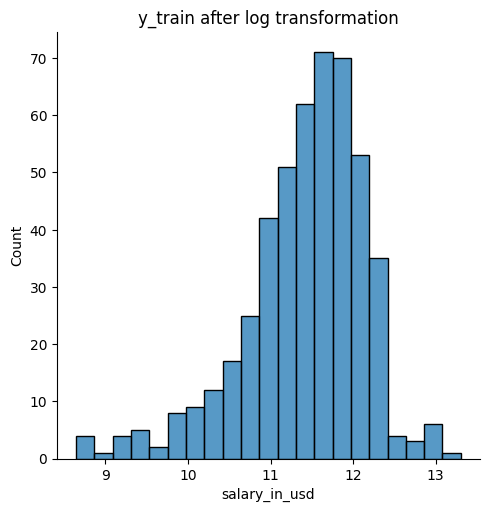

In [362]:
g = sns.displot(data=y_train_log)
g.set(title="y_train after log transformation")
plt.show()

## Modelling

In [169]:
# modelling
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import NotFittedError

In [350]:
pipelines = {
    'rf': make_pipeline(preproc_pipe, OneHotEncoder(), RandomForestRegressor(random_state=1234)),
    'gb': make_pipeline(preproc_pipe, OneHotEncoder(), GradientBoostingRegressor(random_state=1234)),
    'lasso': make_pipeline(preproc_pipe, OneHotEncoder(), Lasso(random_state=1234)),
    'enet': make_pipeline(preproc_pipe, OneHotEncoder(), ElasticNet(random_state=1234)),
    'knn': make_pipeline(preproc_pipe, OneHotEncoder(), KNeighborsRegressor())
}

In [364]:
hypergrid = {
    'rf': {
        'randomforestregressor__min_samples_split':[2,4,6],
        'randomforestregressor__min_samples_leaf':[1,2,3],
        'randomforestregressor__bootstrap': ['True', 'False'],
        'randomforestregressor__n_estimators': [100, 200, 500]
    },
    'gb':{
        'gradientboostingregressor__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99],
        'gradientboostingregressor__n_estimators': [100, 200, 500]
    },
    'ridge':{
        'ridge__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    },
    'lasso':{
        'lasso__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    },
    'enet':{
        'elasticnet__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    },
    'knn':{
        'kneighborsregressor__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10]
    }
}

In [365]:
fit_models = {}

for algo, pipe in pipelines.items():
    model = GridSearchCV(pipe, hypergrid[algo], cv=10, n_jobs=-1)
    
    try:
        print(f'--- starting training for {algo} ---')
        model.fit(X_train, y_train_log)
        fit_models[algo] = model
        print(f'best_score = {round(model.best_score_, 2)}')
        print(f'best_params = {model.best_params_}')
        print(f'--- {algo} has been successfully fit ---')

    except NotFittedError as e:  # specific exception for sklearn models
        print(repr(e))

--- starting training for rf ---
best_score = 0.54
best_params = {'randomforestregressor__bootstrap': 'True', 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 500}
--- rf has been successfully fit ---
--- starting training for gb ---
best_score = 0.52
best_params = {'gradientboostingregressor__alpha': 0.001, 'gradientboostingregressor__n_estimators': 100}
--- gb has been successfully fit ---
--- starting training for lasso ---
best_score = 0.55
best_params = {'lasso__alpha': 0.005}
--- lasso has been successfully fit ---
--- starting training for enet ---
best_score = 0.55
best_params = {'elasticnet__alpha': 0.005}
--- enet has been successfully fit ---
--- starting training for knn ---
best_score = 0.43
best_params = {'kneighborsregressor__n_neighbors': 3}
--- knn has been successfully fit ---


## Evaluation

In [176]:
from sklearn.metrics import r2_score, mean_squared_error

In [242]:
#create table to compare MLA metrics
model_compare_columns = ['Model Name', 'Test R2', 'Test MSE']
model_compare = pd.DataFrame(columns = model_compare_columns)

In [366]:
for algo, model in fit_models.items():
    y_pred = model.predict(X_test)
    print(f'{algo}: R2: {round(r2_score(y_test_log, y_pred), 3)} MSE: {round(mean_squared_error(y_test_log, y_pred), 3)}')


rf: R2: 0.521 MSE: 0.402
gb: R2: 0.547 MSE: 0.381
lasso: R2: 0.558 MSE: 0.371
enet: R2: 0.56 MSE: 0.37
knn: R2: 0.463 MSE: 0.452


In [353]:
model_compare

,Model Name,Test R2,Test MSE


In [ ]:
best_model = fit_models['enet']

## Save the best model for reuse

In [369]:
import pickle

In [371]:
# save the model as pickle
with open('trained_models/ds_salaries_model.pkl', 'wb') as f: 
  pickle.dump(best_model, f)

In [372]:
# reload the saved model
with open('trained_models/ds_salaries_model.pkl', 'rb') as f: 
  reloaded_model = pickle.load(f)

In [373]:
reloaded_model

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('columndropper',
                                                         ColumnDropper()),
                                                        ('countrytocontinenttransformer',
                                                         CountryToContinentTransformer()),
                                                        ('jobtitletransformer',
                                                         JobTitleTransformer()),
                                                        ('currencytransformer',
                                                         CurrencyTransformer())])),
                                       ('onehotencoder', OneHotEncoder()),
                                       ('elasticnet',
                                        ElasticNet(random_state=1234))]),
             n_jobs=-1,
             param_grid={'elasticnet__alpha': [0.001, 0.005, 0.01, 0.05, 0.1,
                                               0.5, 0.99]})